<a href="https://colab.research.google.com/github/zubaerimran/219_projs/blob/master/gman_svhn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# import tensorflow as tf, os
# tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']

# with tf.Session(tpu_address) as session:
#     devices = session.list_devices()
# devices

In [0]:
import numpy as np
import time
import os
import pdb


import tensorflow as tf
from tensorflow.contrib.layers.python.layers import batch_norm

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, accuracy_score

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
#%matplotlib inline

num_disc = 2#discriminators selected
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument("gpu", help="Select a GPU(0/1) to train the model on")
# parser.add_argument("ndisc", help="Select the number of discriminators")
# args = parser.parse_args()
# device = args.gpu
# ndisc = int(args.ndisc)

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"] = str(device)

# print(device, 'selected as the gpu device')
# print('Number of discriminators selected:', ndisc)


x_height, x_width = [32, 32]
num_channels = 3
num_classes = 10
latent_size = 100
labeled_rate = 0.1
g_scale_factor = 1 - 0.75/2
d_scale_factor = 0.25
eps_min = 1e-8 # used to avoid NAN loss
eps_max = 1.0 - eps_min
alpha = 0.2
to_restore = False


root = 'gdrive/My Drive/ijcv_project/gman/gman_svhn_' + str(num_disc) +'D'

save_to = root + '/out/'

if not os.path.exists(save_to):
    os.makedirs(save_to)

log_path = root + '/gman_log.csv'
model_path =root + '/gman_model.ckpt'
model_dir = root + '/'

#Load the train and test data
import scipy.io as sio
dataset = sio.loadmat('gdrive/My Drive/datasets/svhn.mat')

In [0]:
def D(x, dropout_rate, is_training, reuse = True, print_summary = True):
    # discriminator (x -> n + 1 class)

    with tf.variable_scope('Discriminator', reuse = reuse) as scope:
        normal_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
        # layer1 - do not use Batch Normalization on the first layer of Discriminator
        conv1 = tf.layers.conv2d(x, 64, [5, 5],
                                 strides = [2, 2],
                                 padding = 'same',
                                 kernel_initializer=normal_initializer,)
        lrelu1 = tf.maximum(0.2 * conv1, conv1) #leaky relu
        dropout1 = tf.layers.dropout(lrelu1, dropout_rate)

        # layer2
        conv2 = tf.layers.conv2d(dropout1, 128, [3, 3],
                                 strides = [2, 2],
                                 padding = 'same',
                                 kernel_initializer=normal_initializer)
        batch_norm2 = tf.layers.batch_normalization(conv2, training = is_training)
        lrelu2 = tf.maximum(0.2 * batch_norm2, batch_norm2)

        # layer3
        conv3 = tf.layers.conv2d(lrelu2, 256, [2, 2],
                                 strides = [2, 2],
                                 padding = 'same',
                                 kernel_initializer=normal_initializer)
        batch_norm3 = tf.layers.batch_normalization(conv3, training = is_training)
        lrelu3 = tf.maximum(0.2 * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(lrelu3, dropout_rate)

        # layer 4
        conv4 = tf.layers.conv2d(dropout3, 512, [2, 2],
                                 strides = [2, 2],
                                 padding = 'same',
                                 kernel_initializer=normal_initializer)
        # do not use batch_normalization on this layer - next layer, "flatten5",
        # will be used for "Feature Matching"
        lrelu4 = tf.maximum(0.2 * conv4, conv4)

        # layer 5
        flatten_length = lrelu4.get_shape().as_list()[1] * \
                         lrelu4.get_shape().as_list()[2] * lrelu4.get_shape().as_list()[3]
        flatten5 = tf.reshape(lrelu4, (-1, flatten_length)) # used for "Feature Matching" 
        fc5 = tf.layers.dense(flatten5, (num_classes + 1))
        output = tf.nn.softmax(fc5)

        assert output.get_shape()[1:] == [num_classes + 1]

        if print_summary:
            print('Discriminator summary:\n x: %s\n' \
                  ' D1: %s\n D2: %s\n D3: %s\n D4: %s\n' %(x.get_shape(), 
                                                           dropout1.get_shape(),
                                                           lrelu2.get_shape(), 
                                                           dropout3.get_shape(),
                                                           lrelu4.get_shape()))
        return flatten5, fc5, output

In [0]:
alpha = 0.2
def G(z, is_training, reuse = False, print_summary = False):
    # generator (z -> x)

    with tf.variable_scope('Generator', reuse = reuse) as scope:
        normal_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
        # layer 0
        z_ = tf.layers.dense(z, 512*2*2)
        z_reshaped = tf.reshape(z_, (-1, 2, 2, 512))
        z_dense = tf.nn.relu(z_reshaped)

        # layer 1 out: 8x8
        deconv1 = tf.layers.conv2d_transpose(z_dense,
                                             filters = 256,
                                             kernel_size = [5, 5],
                                             strides = [2, 2],
                                             padding = 'same',
                                             kernel_initializer=normal_initializer)
        batch_norm1 = tf.layers.batch_normalization(deconv1, training = is_training)
        relu1 = tf.nn.relu(batch_norm1)
        
        
        
        # layer 2 out: 16x16
        deconv2 = tf.layers.conv2d_transpose(relu1,
                                             filters = 128,
                                             kernel_size = [5, 5],
                                             strides = [2, 2],
                                             padding = 'same',
                                             kernel_initializer=normal_initializer)
        batch_norm2 = tf.layers.batch_normalization(deconv2, training = is_training)
        relu2 = tf.nn.relu(batch_norm2)
        
        
        # layer 3 out:32x32
        deconv3 = tf.layers.conv2d_transpose(relu2,
                                             filters = 64,
                                             kernel_size = [5, 5],
                                             strides = [2, 2],
                                             padding = 'same',
                                             kernel_initializer=normal_initializer)
        batch_norm3 = tf.layers.batch_normalization(deconv3, training = is_training)
        relu3 = tf.nn.relu(batch_norm3)

        
#         # layer 4 out: 64x64
#         deconv4 = tf.layers.conv2d_transpose(lrelu3,
#                                              filters = 64,
#                                              kernel_size = [3, 3],
#                                              strides = [2, 2],
#                                              padding = 'same')
#         batch_norm4 = tf.layers.batch_normalization(deconv4, training = is_training)
#         lrelu4 = tf.nn.leaky_relu(batch_norm4, alpha)
        
        
#         # layer 5 out: 128x128
#         deconv5 = tf.layers.conv2d_transpose(lrelu4,
#                                              filters = 32,
#                                              kernel_size = [3, 3],
#                                              strides = [2, 2],
#                                              padding = 'same')
#         batch_norm5 = tf.layers.batch_normalization(deconv4, training = is_training)
#         lrelu5 = tf.nn.leaky_relu(batch_norm5, alpha)
        
        
        # layer 5 - do not use Batch Normalization on the last layer of Generator
        deconv4 = tf.layers.conv2d_transpose(relu3,
                                             filters = num_channels,
                                             kernel_size = [3, 3],
                                             strides = [2, 2],
                                             padding = 'same',
                                             kernel_initializer=normal_initializer)
        tanh4 = tf.tanh(deconv4)
        
        print(tanh4.shape)
                                             
                                             
        assert tanh4.get_shape()[1:] == [x_height, x_width, num_channels]
        
        if print_summary:
            print('Generator summary:\n z: %s\n' \
                  ' G0: %s\n G1: %s\n G2: %s\n G3: %s\n G4: %s\n' %(z_.get_shape(),
                                                                    z_reshaped.get_shape(),
                                                                    relu1.get_shape(),
                                                                    relu2.get_shape(),
                                                                    relu3.get_shape(),
                                                                    #lrelu4.get_shape(),
                                                                    tanh4.get_shape()))
        return tanh4

In [0]:
#random weights for the discriminators 
w_D = np.random.uniform(0, 1.0, num_disc)
    
def ensemble_gm(list_of_numbers):
  #print(list_of_numbers)
  log_ =  tf.log(-clip_value(list_of_numbers))
  gm = -tf.exp(clip_value(log_/num_disc))
  return gm

def normalize(x):
    # normalize data
    #x = (x - 127.5) / 127.5
    return x.reshape((-1, x_height, x_width, num_channels))

In [0]:
# #For single D
# def build_model(x_real, z, label, dropout_rate, is_training, print_summary = False):
#     # build model
#     D_real_features, D_real_logit, D_real_prob = D(x_real, dropout_rate, is_training,
#                                                    reuse = False, print_summary = print_summary)
#     x_fake = G(z, is_training, reuse = False, print_summary = print_summary)
#     D_fake_features, D_fake_logit, D_fake_prob = D(x_fake, dropout_rate, is_training,
#                                                    reuse = True, print_summary = print_summary)

#     return D_real_features, D_real_logit, D_real_prob, D_fake_features, D_fake_logit, D_fake_prob, x_fake

#For multiple D
# def build_model(x_real, z, label, dropout_rate, is_training, print_summary = False):
#     # build model
    
       
#     #Initialize all for D
#     D_fake_features, D_fake_logit, D_fake_prob = [0]*num_disc, [0]*num_disc, [0]*num_disc
#     D_real_features, D_real_logit, D_real_prob = [0]*num_disc, [0]*num_disc, [0]*num_disc
    
#     for i in range(num_disc):
           
      
#       #Encoded vector to G
#       if i is 0:
#         reus = False
#       else:
#         reus = True
      
    
#       #Random noise to G
#       x_fake = G(z, is_training, reuse = reus, print_summary = print_summary)
    
#       #fake image to D
#       D_fake_features[i], D_fake_logit[i], D_fake_prob[i] = D(x_fake, dropout_rate, is_training, 
#                                                    reuse = reus, print_summary = print_summary)
    
    
#       # Real image input -> D
#       D_real_features[i], D_real_logit[i], D_real_prob[i] = D(x_real, dropout_rate, is_training, 
#                                                    reuse = True, print_summary = print_summary)
   
#     ind = np.random.randint(0, num_disc) 
    
#     return D_real_features[ind], D_real_logit[ind], D_real_prob[ind], \
#            D_fake_features[ind], D_fake_logit[ind], D_fake_prob[ind],  \
#            x_fake #

def build_model(x_real, z, label, dropout_rate, is_training, print_summary = False):
    #Initialize all for D
    
    D_fake_features, D_fake_logit, D_fake_prob = [0]*num_disc, [0]*num_disc, [0]*num_disc
    D_real_features, D_real_logit, D_real_prob = [0]*num_disc, [0]*num_disc, [0]*num_disc
    
    for i in range(num_disc):
           
      
      #Encoded vector to G
      if i is 0:
        reus = False
      else:
        reus = True
      
      
      #real image to E
    
      #Random noise to G
      x_fake = G(z, is_training, reuse = reus, print_summary = print_summary)
    
      #tilde image to D
      D_fake_features[i], D_fake_logit[i], D_fake_prob[i] = D(x_fake, dropout_rate, is_training, 
                                                   reuse = reus, print_summary = print_summary)
    
    
      # Real image input -> D
      D_real_features[i], D_real_logit[i], D_real_prob[i] = D(x_real, dropout_rate, is_training, 
                                                   reuse = True, print_summary = print_summary)
    
    #Calculate the combined feedback
   
    D_fake_features_final = 0.
    D_fake_logit_final = 0.
    D_fake_prob_final = 0.
    
    D_real_features_final = 0.
    D_real_logit_final = 0.
    D_real_prob_final = 0.
    
#     for i in range(num_disc):
    
#       D_fake_features_final *= tf.pow(D_fake_features[i], w_D[i])
#       D_fake_logit_final *= tf.pow(D_fake_logit[i], w_D[i])
#       D_fake_prob_final *= tf.pow(D_fake_prob[i], w_D[i])
        
#       D_real_features_final *= tf.pow(D_real_features[i], w_D[i])
#       D_real_logit_final *= tf.pow(D_real_logit[i], w_D[i])
#       D_real_prob_final *= tf.pow(D_real_prob[i], w_D[i])


    for i in range(num_disc):
    
      D_fake_features_final += D_fake_features[i] * w_D[i]
      D_fake_logit_final += D_fake_logit[i] * w_D[i]
      D_fake_prob_final += D_fake_prob[i] * w_D[i]
        
      D_real_features_final += D_real_features[i] * w_D[i]
      D_real_logit_final += D_real_logit[i] * w_D[i]
      D_real_prob_final += D_real_prob[i] * w_D[i]


    
#     D_tilde_features_final = ensemble_gm(D_tilde_features_final)
#     D_tilde_logit_final = ensemble_gm(D_tilde_logit_final)
#     D_tilde_prob_final = ensemble_gm(D_tilde_prob_final)
    
#     D_fake_features_final = ensemble_gm(D_fake_features_final)
#     D_fake_logit_final = ensemble_gm(D_fake_logit_final)
#     D_fake_prob_final = ensemble_gm(D_fake_prob_final)
    
#     D_real_features_final = ensemble_gm(D_real_features_final)
#     D_real_logit_final = ensemble_gm(D_real_logit_final)
#     D_real_prob_final = ensemble_gm(D_real_prob_final)
    
    D_fake_features_final = D_fake_features_final / num_disc
    D_fake_logit_final = D_fake_logit_final / num_disc
    D_fake_prob_final = D_fake_prob_final / num_disc
    
    D_real_features_final = D_real_features_final / num_disc
    D_real_logit_final = D_real_logit_final / num_disc
    D_real_prob_final = D_real_prob_final / num_disc
     
    #print('Logit size....', D_real_logit_final.get_shape())####
    return D_real_features_final, D_real_logit_final, D_real_prob_final, \
           D_fake_features_final, D_fake_logit_final, D_fake_prob_final,  \
           x_fake #

In [0]:
def clip_value(value):
  value = tf.clip_by_value(value, eps_min, eps_max)
  return value

In [0]:
def prepare_labels(label):
    # add extra label for fake data
    extended_label = tf.concat([label, tf.zeros([tf.shape(label)[0], 1])], axis = 1)

    return extended_label

In [0]:
def loss_accuracy(D_real_features, D_real_logit, D_real_prob, D_fake_features,
                  D_fake_logit, D_fake_prob, extended_label, labeled_mask):
    epsilon = 1e-8 # used to avoid NAN loss
    # *** Discriminator loss ***
    # supervised loss
    # which class the real data belongs to
    tmp = tf.nn.softmax_cross_entropy_with_logits(logits = D_real_logit,
                                                  labels = extended_label)
    D_L_supervised = tf.reduce_sum(labeled_mask * tmp) / tf.reduce_sum(labeled_mask) # to ignore
                                                                                     # unlabeled
                                                                                     # data

    # unsupervised loss
    # data is real
    prob_real_be_real = 1 - D_real_prob[:, -1] + epsilon
    tmp_log = tf.log(prob_real_be_real)
    D_L_unsupervised1 = -1 * tf.reduce_mean(tmp_log)

    # data is fake
    prob_fake_be_fake = D_fake_prob[:, -1] + epsilon
    tmp_log = tf.log(prob_fake_be_fake)
    D_L_unsupervised2 = -1 * tf.reduce_mean(tmp_log)

    D_L = D_L_supervised + D_L_unsupervised1 + D_L_unsupervised2

    # *** Generator loss ***
    # fake data is mistaken to be real
    prob_fake_be_real = 1 - D_fake_prob[:, -1] + epsilon
    tmp_log =  tf.log(prob_fake_be_real)
    G_L1 = -1 * tf.reduce_mean(tmp_log)

    # Feature Maching
    tmp1 = tf.reduce_mean(D_real_features, axis = 0)
    tmp2 = tf.reduce_mean(D_fake_features, axis = 0)
    G_L2 = tf.reduce_mean(tf.square(tmp1 - tmp2))

    G_L = G_L1 + G_L2

    # accuracy
    correct_prediction = tf.equal(tf.argmax(D_real_prob[:, :-1], 1),
                                  tf.argmax(extended_label[:, :-1], 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    predicted = tf.argmax(D_real_prob[:, :-1], 1)
    actual = tf.argmax(extended_label[:, :-1], 1)
    

    return D_L, G_L, accuracy, actual, predicted

In [0]:
def optimizer(D_Loss, G_Loss, D_learning_rate, G_learning_rate):
    # D and G optimizer
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(extra_update_ops):
        all_vars = tf.trainable_variables()
        D_vars = [var for var in all_vars if var.name.startswith('Discriminator')]
        G_vars = [var for var in all_vars if var.name.startswith('Generator')]

        D_optimizer = tf.train.AdamOptimizer(D_learning_rate).minimize(D_Loss, var_list = D_vars)
        G_optimizer = tf.train.AdamOptimizer(G_learning_rate).minimize(G_Loss, var_list = G_vars)

        return D_optimizer, G_optimizer

Visualize

In [0]:
def plot_fake_data(data, grid_size = [5, 5]):
    # visualize some data generated by G
    _, axes = plt.subplots(figsize = grid_size, nrows = grid_size[0], ncols = grid_size[1],
                           sharey = True, sharex = True)

    size = grid_size[0] * grid_size[1]
    index = np.int_(np.random.uniform(0, data.shape[0], size = (size)))
    figs = data[index].reshape(-1, x_height, x_width, num_channels)

    for idx, ax in enumerate(axes.flatten()):
        ax.axis('off')
        ax.imshow(figs[idx])
    plt.tight_layout()
    plt.show()

In [0]:
import matplotlib.gridspec as gridspec
import cv2

def plot(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)
    
    #samples = samples*127.5 + 127.5
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample)

    return fig

def im_resize(img, des_side):
    # get height and width of image
    height, width = img.shape[:2]
    
    #For rgb to grayscale
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #sqaure image with side equal to height of rectangle
    img_sq = cv2.resize(img,(des_side,des_side),interpolation = cv2.INTER_CUBIC)
    return img_sq

Train Model

In [0]:
def save_model_on_imporvemnet(file_path, sess, cv_acc, cv_accs):
  #  # save model when there is improvemnet in cv_acc value
    if cv_accs == [] or cv_acc > np.max(cv_accs):
        saver = tf.train.Saver(max_to_keep = 1)
        saver.save(sess, file_path)
        print('Model saved')
    print('')

In [0]:
def get_labled_mask(labeled_rate, batch_size):
    # get labeled mask to mask some data unlabeled
    labeled_mask = np.zeros([batch_size], dtype = np.float32)
    labeled_count = np.int(batch_size * labeled_rate)
    labeled_mask[range(labeled_count)] = 1.0
    #np.random.shuffle(labeled_mask)

    return labeled_mask

In [0]:
def log_loss_acc(file_path, epoch, train_loss_D, train_loss_G, train_Acc,
                 cv_loss_D, cv_loss_G, cv_Acc, log_mode = 'a'):
    # log train and cv losses as well as accuracy
    mode = log_mode if epoch == 0 else 'a'

    with open(file_path, mode) as f:
        if mode == 'w':
            header = 'epoch, train_loss_D, train_loss_G, train_Acc,' \
                     'cv_loss_D, cv_loss_G, cv_Acc\n'
            f.write(header)

        line = '%d, %f, %f, %f, %f, %f, %f\n' %(epoch, train_loss_D, train_loss_G, train_Acc,
                                                cv_loss_D, cv_loss_G, cv_Acc)
        f.write(line)
        
import csv
def csv_dataread(filename):
    read_data = []
    with open(filename, newline='\n') as csvfile: #newline is 
        data_reader = csv.reader(csvfile, delimiter=',')
        
        #each row at a time
        for row in data_reader:
            read_data.append(row[6]) #row number of cv_accuracy in the csv file
    return read_data

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
(?, 32, 32, 3)
Generator summary:
 z: (?, 2048)
 G0: (?, 2, 2, 512)
 G1: (?, 4, 4, 256)
 G2: (?, 8, 8, 128)
 G3: (?, 16, 16, 64)
 G4: (?, 32, 32, 3)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.dropout instead.
Discriminator summary:
 x: (?, 32, 32, 3)
 D1: (?, 16, 16, 64)
 D2: (?, 8, 8, 128)
 D3: (?, 4, 4, 256)
 D4: (?, 2, 2, 512)

Discriminator summary:
 x: (?, 32, 32, 3)
 D1: (?, 16, 16, 64)
 D2: (?, 8, 8, 128)
 D3: (?, 4, 4, 256)
 D4: (?, 2, 2, 512)

(?, 32, 32, 3)
Generator summary:
 z: (?, 2048)
 G0: (?, 2, 2, 512)
 G1: (?, 4, 4, 256)
 G2: (?, 8, 8, 128)
 G3: (?, 16, 16, 64)
 G4: (?, 32, 32, 3)

Discriminator summary:
 x: (?, 32, 32, 3)
 D1: (?, 16, 16

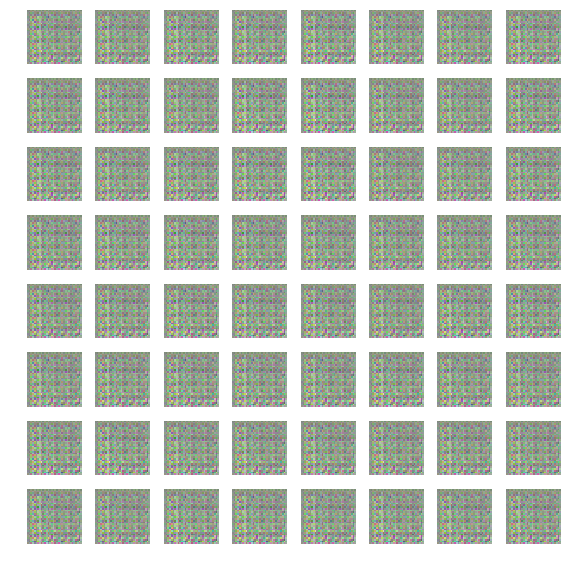

In [0]:
batch_size = 512
prev_epoch = -1
epochs = 1001


#Initialize outputs
train_D_losses, train_G_losses, train_Accs = [], [], []
cv_D_losses, cv_G_losses, cv_Accs = [], [], []

#reset default graph
tf.reset_default_graph()

#Graph inputs
x = tf.placeholder(tf.float32, name = 'x', shape = [None, x_height, x_width, num_channels])
label = tf.placeholder(tf.float32, name = 'label', shape = [None, num_classes])
labeled_mask = tf.placeholder(tf.float32, name = 'labeled_mask', shape = [None])
z = tf.placeholder(tf.float32, name = 'z', shape = [None, latent_size])
dropout_rate = tf.placeholder(tf.float32, name = 'dropout_rate')
is_training = tf.placeholder(tf.bool, name = 'is_training')
G_learning_rate = tf.placeholder(tf.float32, name = 'G_learning_rate')
D_learning_rate = tf.placeholder(tf.float32, name = 'D_learning_rate')


##Define the model
model = build_model(x, z, label, dropout_rate, is_training, print_summary = True)
    
    
D_real_features, D_real_logit, D_real_prob, \
D_fake_features, D_fake_logit, D_fake_prob, \
fake_data = model #

#Results
extended_label = prepare_labels(label)

loss_acc  = loss_accuracy(D_real_features, D_real_logit, D_real_prob,
                          D_fake_features, D_fake_logit, D_fake_prob,
                              extended_label, labeled_mask)

D_L, G_L, accuracy, actual, predicted = loss_acc # D_loss, G_loss, accuracy 
D_optimizer, G_optimizer = optimizer(D_L, G_L, G_learning_rate, D_learning_rate) 


# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver(max_to_keep=1)


train_images = dataset['train_images']
train_labels = dataset['train_labels']
test_images = dataset['test_images']
test_labels = dataset['test_labels']


# Running first session
print("Training...")
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    
    if to_restore:
      # Restore model weights from previously saved model if any
      chkpt_fname = tf.train.latest_checkpoint(model_dir)
      saver.restore(sess, chkpt_fname)
      prev_epoch = int(chkpt_fname.split('-')[len(chkpt_fname.split('-'))-1])
      print("Model restored at %d from %s" % (prev_epoch, chkpt_fname))
      log_res = csv_dataread(log_path)
      cv_Accs = [float(i) for i in log_res[1:]]
    else:
      prev_epoch = -1
      print("Training the model from scratch....\n")

    for epoch in range(prev_epoch+1, epochs):
      t_total = 0
      train_size = train_labels.shape[0]
      n_iter = int(train_size / batch_size) +  1 
      st_ind = 0
      train_acc = []
      
      for iter in range(int(train_images.shape[0] / batch_size) + 1):
        t_start = time.time()
                
        if iter == n_iter - 1:
            st_ind = train_size - batch_size - 1
            idx = np.random.randint(st_ind, train_size, batch_size)
        else:
            last_ind = st_ind + batch_size
            idx = np.random.randint(st_ind, last_ind, batch_size)
            st_ind += batch_size
        #print(iter, idx)
  
        #idx = np.random.randint(0, train_images.shape[0], batch_size)
        batch_images = train_images[idx]
        batch_labels = train_labels[idx]
        batch = (batch_images, batch_labels)
                
        batch_z = np.random.uniform(-1.0, 1.0, size = (batch_size, latent_size))
        mask = get_labled_mask(labeled_rate, batch_size)
                
        train_feed_dictionary = {x:  normalize(batch[0]),
                                         z: batch_z,
                                         label: batch[1],
                                         labeled_mask: mask,
                                         dropout_rate: 0.2,
                                         G_learning_rate: 0.0002,
                                         D_learning_rate: 0.0002,
                                         is_training: True}

        D_optimizer.run(feed_dict = train_feed_dictionary)
        G_optimizer.run(feed_dict = train_feed_dictionary)

        train_D_loss = D_L.eval(feed_dict = train_feed_dictionary)
        train_G_loss = G_L.eval(feed_dict = train_feed_dictionary)
        train_accuracy = accuracy.eval(feed_dict = train_feed_dictionary)
        t_total += (time.time() - t_start)
        
      train_Accs.append(train_accuracy)     
      #pdb.set_trace()
      print('epoch: ', epoch, 'time: ',t_total, 'train_G_Loss: ',train_G_loss, 'train_D_Loss: ', 
                  train_D_loss, 'train_acc: ', train_accuracy)
      
      #print("Cross validation!")
      if epoch % 1 == 0:
        # Cross-Validation
       # Cross-Validation
        cv_size = test_labels.shape[0]
        n_it = int(cv_size / batch_size) +  1 
        st_ind = 0
        cv_acc = []
        actuals = []
        predicts = []
      
        for test_it in range(n_it):
          if test_it == n_it - 1:
            st_ind = cv_size - batch_size - 1
            idx = np.random.randint(st_ind, cv_size, batch_size)
          else:
            last_ind = st_ind + batch_size
            idx = np.random.randint(st_ind, last_ind, batch_size)
            st_ind += batch_size
          #print(test_it, idx)
  
          batch_images = test_images[idx]
          batch_labels = test_labels[idx]
          test_batch = (batch_images, batch_labels)
        
          cv_batch_z = np.random.uniform(-1.0, 1.0, size = (batch_size, latent_size))
          mask = get_labled_mask(1, batch_size)
          cv_feed_dictionary = {x: normalize(test_batch[0]),
                                  z: cv_batch_z,
                                  label: test_batch[1],
                                  labeled_mask: mask,
                                  dropout_rate: 0.0,
                                  is_training: False}

          cv_D_loss = D_L.eval(feed_dict = cv_feed_dictionary)
          cv_G_loss = G_L.eval(feed_dict = cv_feed_dictionary)
          cv_accuracy = accuracy.eval(feed_dict = cv_feed_dictionary)
          cv_acc.append(cv_accuracy)
          actual_ = actual.eval(feed_dict=cv_feed_dictionary)
          predicted_ = predicted.eval(feed_dict=cv_feed_dictionary)
          actuals.append(actual_)
          predicts.append(predicted_)
      
        cv_accuracy = np.mean(cv_acc)
        if epoch==0 or cv_accuracy>np.max(cv_Accs):
            actuals = np.reshape(actuals, [-1])    
            predicts = np.reshape(predicts, [-1])
            target_names = ['airplane', 'automobile', 'bird', 'cat',' deer', 'dog', 'frog', 'horse', 'ship', 'truck']

            print(classification_report(actuals, predicts, target_names=target_names)) 
            print(accuracy_score(actuals, predicts))
            save_path = saver.save(sess, model_path, global_step=epoch)
            print("Model saved in file: %s" % save_path)

        
        print('\ncv_G_Loss: %f, cv_D_loss: %f, cv_acc: %f\n' %(cv_G_loss,
                                                                 cv_D_loss,
                                                                 cv_accuracy))
            
       
        log_loss_acc(log_path, epoch, train_D_loss, train_G_loss, train_accuracy, cv_D_loss, cv_G_loss, cv_accuracy, log_mode = 'w')
 
        cv_Accs.append(cv_accuracy)

        if epoch%5==0:
          fakes = fake_data.eval(feed_dict = train_feed_dictionary)
          rescaled_fakes = (fakes + 1.0)/2.0 
          plot_fake_data(rescaled_fakes[:64], [8,8])
          fig = plot(rescaled_fakes[:64])
          plt.savefig((save_to + 'G@epoch{}.png').format(str(epoch).zfill(3)), bbox_inches = "tight")
          plt.close()